In [89]:
import pandas as pd   
import matplotlib.pyplot as plt  
import seaborn as sns  

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [90]:
#чтение данных из файла

df_train = pd.read_csv(r'D:\work_work\tasks\modul_2\project\heart_adapt_train (1).csv')
df_test = pd.read_csv(r'D:\work_work\tasks\modul_2\project\heart_adapt_test.csv')

**Анализ датафрейма**

In [91]:
df_train.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,74.0,M,NAP,138.0,NaN,0,Normal,116,N,0.2,Up,0
1,58.0,M,NAP,132.0,224.0,0,LVH,173,N,3.2,Up,1
2,44.0,M,ATA,150.0,288.0,0,Normal,150,Y,3.0,Flat,1
3,50.0,M,ASY,144.0,349.0,0,LVH,120,Y,1.0,Up,1
4,NaN,M,ASY,145.0,248.0,0,Normal,96,Y,2.0,Flat,1


In [92]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589 entries, 0 to 588
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             533 non-null    float64
 1   Sex             589 non-null    object 
 2   ChestPainType   589 non-null    object 
 3   RestingBP       588 non-null    float64
 4   Cholesterol     462 non-null    float64
 5   FastingBS       589 non-null    int64  
 6   RestingECG      589 non-null    object 
 7   MaxHR           589 non-null    int64  
 8   ExerciseAngina  589 non-null    object 
 9   Oldpeak         589 non-null    float64
 10  ST_Slope        589 non-null    object 
 11  HeartDisease    589 non-null    int64  
dtypes: float64(4), int64(3), object(5)
memory usage: 55.3+ KB


In [93]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197 entries, 0 to 196
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             177 non-null    float64
 1   Sex             197 non-null    object 
 2   ChestPainType   197 non-null    object 
 3   RestingBP       197 non-null    float64
 4   Cholesterol     160 non-null    float64
 5   FastingBS       197 non-null    int64  
 6   RestingECG      197 non-null    object 
 7   MaxHR           197 non-null    int64  
 8   ExerciseAngina  197 non-null    object 
 9   Oldpeak         197 non-null    float64
 10  ST_Slope        197 non-null    object 
 11  HeartDisease    197 non-null    int64  
dtypes: float64(4), int64(3), object(5)
memory usage: 18.6+ KB


Данные содержат 11 признаков, среди которых целевой HeartDisease, отвечающий за наличие заболеваний сердца: 0 - норма, 1 - наличие заболевания. Тренировочные данные содержат 589 строк, тестовые 197. Среди данных есть 5 категориальных признаков, которые являются важными и нуждаются в преобразовании.

In [94]:
df_train.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,533.000000,588.000000,462.000000,589.000000,589.000000,589.000000,589.000000
mean,54.195122,133.358844,245.632035,0.258065,134.893039,0.937521,0.646859
std,9.532661,18.851852,58.599184,0.437942,24.942596,1.071318,0.478352
min,28.000000,80.000000,85.000000,0.000000,63.000000,-2.600000,0.000000
25%,48.000000,120.000000,209.000000,0.000000,117.000000,0.000000,0.000000
50%,55.000000,130.000000,240.000000,0.000000,135.000000,0.800000,1.000000
75%,61.000000,144.000000,279.750000,1.000000,154.000000,1.600000,1.000000
max,77.000000,200.000000,603.000000,1.000000,195.000000,5.000000,1.000000


**Информация о признаках**
Возраст: возраст пациента [лет]  
Пол: пол пациента [М: Мужской, Ж: Женский]  
ChestPainType: тип боли в груди [TA: типичная стенокардия, ATA: атипичная стенокардия, NAP: неангинозная боль, ASY: бессимптомная]  
RestingBP: артериальное давление в состоянии покоя [мм рт. ст.]  
Холестерин: сывороточный холестерин [мм/дл]  
FastingBS: уровень сахара в крови натощак [1: если FastingBS > 120 мг/дл, 0: в противном случае]  
RestingECG: результаты электрокардиограммы в состоянии покоя [Норма: норма, ST: наличие аномалии ST-T (инверсия зубца T и/или элевация или депрессия ST > 0,05 мВ), ГЛЖ: наличие вероятной или определенной гипертрофии левого желудочка по критериям Эстеса]  
MaxHR: максимальная достигнутая частота сердечных сокращений [Числовое значение от 60 до 202]  
ExerciseAngina: стенокардия, вызванная физическим напряжением [Y: Да, N: Нет]  
Oldpeak: oldpeak = ST [Числовое значение, измеренное в депрессии]  
ST_Slope: наклон сегмента ST пиковой нагрузки [Up: восходящий, Flat: плоский, Down: нисходящий]  
HeartDisease: выходной класс [1: заболевание сердца, 0: норма]  

array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'RestingBP'}>,
        <Axes: title={'center': 'Cholesterol'}>],
       [<Axes: title={'center': 'FastingBS'}>,
        <Axes: title={'center': 'MaxHR'}>,
        <Axes: title={'center': 'Oldpeak'}>],
       [<Axes: title={'center': 'HeartDisease'}>, <Axes: >, <Axes: >]],
      dtype=object)

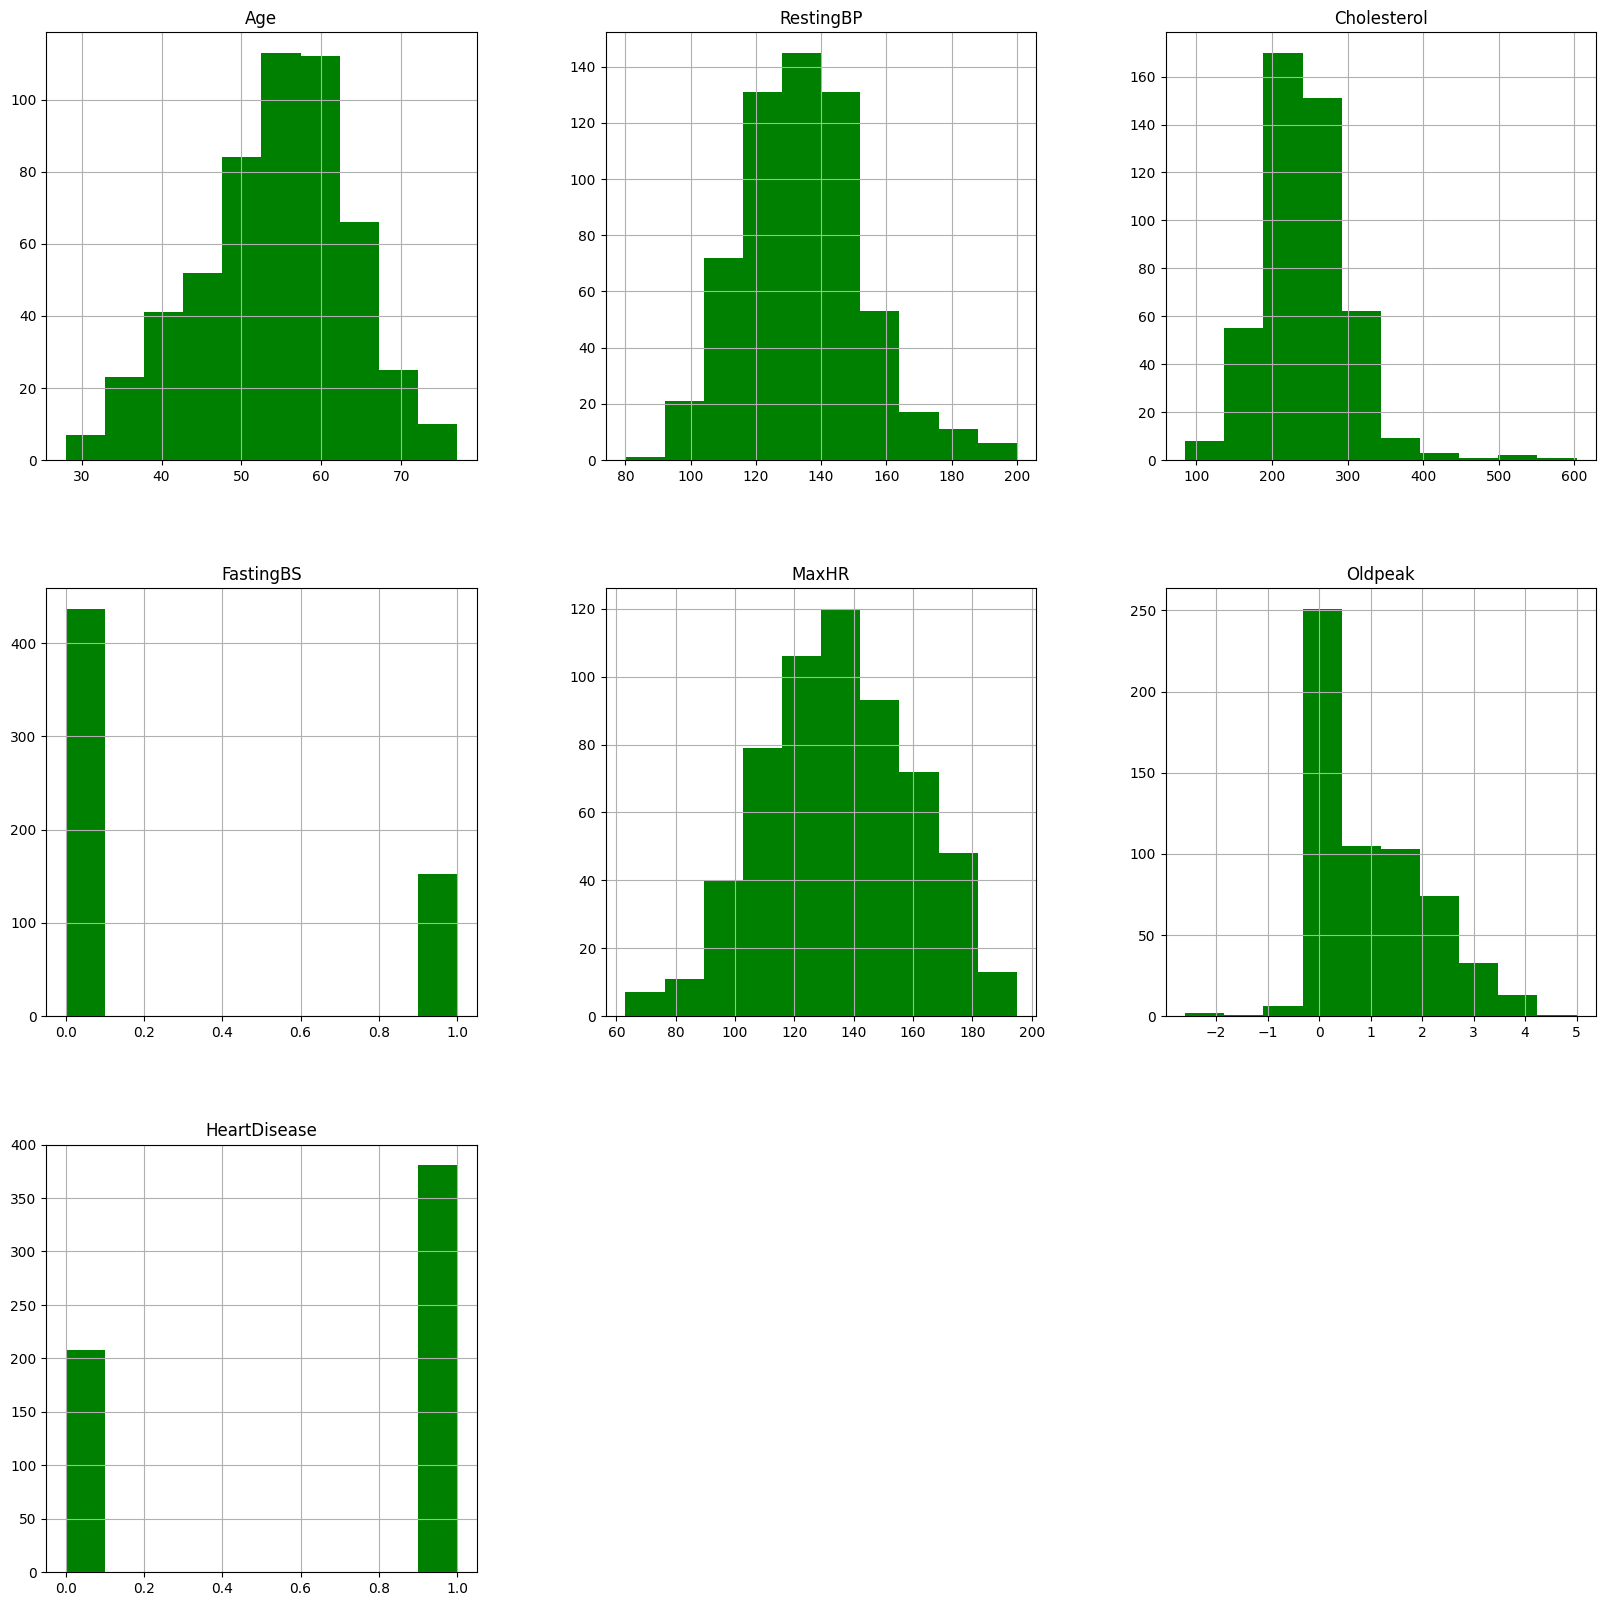

In [103]:

df_train.hist(figsize=(20, 20), color = 'g')

Все небинарные числовые признаки имеют нормальное распределение, поэтому к ним можно применить StandartScaler()

**Построение модели машинного обучения**

Целевой признак бинарный, поэтому будет решаться задача классификации.

In [95]:
# отделение целевого признака от остальных, X - признаки, y - целевой признак
for_del = []
for_del.append('HeartDisease')
X_train = df_train.drop(for_del, axis = 1)
X_test = df_test.drop(for_del, axis = 1)

y_train = df_train['HeartDisease']
y_test = df_test['HeartDisease']

In [96]:
#проверка сбалансированности классов

print('Тренировочные данные', y_train.value_counts())
print('Тестовые данные', y_test.value_counts())

Тренировочные данные HeartDisease
1    381
0    208
Name: count, dtype: int64
Тестовые данные HeartDisease
1    127
0     70
Name: count, dtype: int64


В классах присутствует дисбаланс, однако не критичный

In [105]:
#кодирвоание категориальных признаков one - hot encoding, один из закодированных столбцов удаляется, чтобы избежать мультиколлинеарности
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop = ('first')))
])

# Масштабирование числовых признаков 
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Объединение преобразований единый трансформер
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, list(df_train.select_dtypes('object').columns) ),
        ('num', numerical_transformer, ['FastingBS', 'MaxHR'])
    ])

# Создание пайплайна
pipeline = Pipeline([('preprocessor', preprocessor),
    ('model', DecisionTreeClassifier(random_state=42, class_weight = 'balanced')) 
])

# Гиперпараметры для GridSearchCV
param_grid = [
    {
        'model': [LogisticRegression(random_state=42)],
        'model__C': [0.1, 1, 10]
    }, 
    {
        'model': [DecisionTreeClassifier(random_state=42)],
        'model__max_depth': [2, 4, 8, 15, 30, 45],
    }
]
# Инициализация GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring='roc_auc')

# Обучение модели
grid_search.fit(X_train, y_train)

# Вывод наилучших гиперпараметров
print("Лучшие гиперпараметры:", grid_search.best_params_)

y_pred_proba = grid_search.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("Значение метрики на тестовой выборке с наилучшей моделью:", roc_auc)
roc_auc_train = roc_auc_score(y_train, grid_search.predict_proba(X_train)[:, 1])
print('Значение метрики на тренировочной выборке', roc_auc_train)

Лучшие гиперпараметры: {'model': LogisticRegression(random_state=42), 'model__C': 1}
Значение метрики на тестовой выборке с наилучшей моделью: 0.9065804274465691
Значение метрики на тренировочной выборке 0.9361561175045428


In [106]:
grid_search.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['Sex', 'ChestPainType',
                                                   'RestingECG',
                                                   'ExerciseAngina',
                                                   'ST_Slope']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['FastingBS', 'MaxHR'])])),
                ('model', LogisticRegression(C=1, random_state=42))])

**Вывод**: в созданном pipeline получилось достичь значения метрики roc auc в 90,7% на тестовой выборке и в 93,6% на тренировочной выборке, что свидетельствует о несильном переобучении модели и ее высоком качестве. Для преобразования числовых признаков был применен StandartScaler, тк числовые признаки имеют нормальное распределение. Для кодирования категориальных переменных был применен one hot encoding. Параметры были подобраны с помощью GridSearchCV. Наилучшая метрика получилась при применении модели логистической регрессии с параметром 'model__C': 1.